<a href="https://colab.research.google.com/github/lukegriffiths/daylight_hours/blob/master/daylight_hours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import numpy as np
import requests
import lxml.html as lh
import pandas as pd
from matplotlib import pyplot as plt

In [0]:
def make_dataframe_from_tr_elements(tr_elements):
  """
  Make a Pandas DataFrame from table elements
  Adapted from https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
  """

  # get column names
  col=[]
  i=0 #For each row, store each first element (header) and an empty list
  for t in tr_elements[0]:
      i+=1
      name=t.text_content()
      #print("{} {}".format(i,name))
      col.append((name,[]))

  # get data
  for j in range(1,len(tr_elements)):
      T = tr_elements[j]
      i=0 # column index initiated at 0
      for t in T.iterchildren():
        data=t.text_content() 
        #if i>0: 
        data = str(data)
        col[i][1].append(data)
        i+=1
  Dict = {title:column for (title,column) in col}
  df = pd.DataFrame(Dict)
  df.columns = df.columns.str.replace(' ', '') # remove whitespace from column names

  return df

def get_table_elements_from_url(url):
  """
  Make a Pandas DataFrame from table elements
  Adapted from https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
  """
  print("Getting data from: {}".format(url))
  page = requests.get(url)
  doc = lh.fromstring(page.content) # store contents of the website
  tr_elements = doc.xpath('//tr') # Parse all data that are stored between <tr>..</tr> of HTML, here that is 3 tables (sunrise, sunset, midday)
  print("Total number of table elements: {}".format(len(tr_elements)))
  return tr_elements

def get_sunrise_sunset_df_from_lat_long_year(latitude, longitude, year):
  url = "https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat={}&lon={}&year={}".format(latitude, longitude, year)
  tr_elements = get_table_elements_from_url(url)
  tr_sunrise_elements = tr_elements[:32] # sunrise table: 32 elements = 1 header row + 31 days
  tr_sunset_elements = tr_elements[32:64] # sunset table: 32 elements = 1 header row + 31 days
  df_sunrise = make_dataframe_from_tr_elements(tr_sunrise_elements)
  df_sunset = make_dataframe_from_tr_elements(tr_sunset_elements)
  return df_sunrise, df_sunset


In [278]:
# Logitude and latitude from https://www.gps-latitude-longitude.com/gps-coordinates-of-oslo 
# URL can be generalised to: https://www.gps-latitude-longitude.com/gps-coordinates-of-TOWN_NAME
# Longitude of Oslo: 10.7522454
# Latitude of Oslo: 59.9138688
# Longitude of Plogoff: -4.666499
# Latitude of Plogoff: 48.036674
# Longitude of Strasbourg: 7.7521113
# Latitude of Strasbourg: 48.5734053

year = 2020

df_sunrise_oslo, df_sunset_oslo = get_sunrise_sunset_df_from_lat_long_year(latitude=59.9138688, longitude=10.7522454, year=year)
df_sunrise_plogoff, df_sunset_plogoff = get_sunrise_sunset_df_from_lat_long_year(latitude=48.036674, longitude=-4.666499, year=year)
df_sunrise_strasbourg, df_sunset_strasbourg = get_sunrise_sunset_df_from_lat_long_year(latitude=48.5734053, longitude=7.7521113, year=year)


Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=59.9138688&lon=10.7522454&year=2020
Total number of table elements: 96
Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=48.036674&lon=-4.666499&year=2020
Total number of table elements: 96
Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=48.5734053&lon=7.7521113&year=2020
Total number of table elements: 96


In [0]:
# Get array from each dataframe 
def get_1d_array_of_times_from_df(times_df):
  month_columns = times_df.columns[1:] # list of the month column names
  times_df = times_df[month_columns].apply(pd.to_datetime, format='%H:%M', errors='coerce') # from string to datetime
  #times_df = times_df[month_columns].apply(pd.to_timedelta, errors='coerce') # from string to timedelta
  times_array = times_df.values.transpose().reshape(-1,1) # make into long array of times
  times_array = times_array[~np.isnan(times_array)] # remove all NaTs
  return times_array

sunrise_oslo = get_1d_array_of_times_from_df(df_sunrise_oslo)
sunset_oslo = get_1d_array_of_times_from_df(df_sunset_oslo)

sunrise_strasbourg = get_1d_array_of_times_from_df(df_sunrise_strasbourg)
sunset_strasbourg = get_1d_array_of_times_from_df(df_sunset_strasbourg)

sunrise_plogoff = get_1d_array_of_times_from_df(df_sunrise_plogoff)
sunset_plogoff = get_1d_array_of_times_from_df(df_sunset_plogoff)


In [372]:
# Keep only dates that have times

def get_daily_dataframe_from_df(times_df):
  days = []
  time = []
  month = []
  for i, month_column in enumerate(times_df.columns[1:]):
    df_month = times_df[~(times_df[month_column]=='')] # dataframe with number of days in month
    days = np.append(days, df_month['Day'].values)
    time = np.append(time, df_month[month_column].values)
    month = np.append(month, np.array([i+1]*len(df_month)))
 
  data_for_month = {'Time of day':time, 'day': days, 'month':month}
  df_daily = pd.DataFrame(data_for_month)
  df_daily['year'] = year
  df_daily['Date'] = pd.to_datetime(df_daily[['day', 'month', 'year']], format='%d%m%Y') 
  df_daily['Time of day'] = df_daily['Time of day'].apply(pd.to_datetime, format='%H:%M', errors='coerce')
  return df_daily


df_daily_sunrise_oslo = get_daily_dataframe_from_df(df_sunrise_oslo)
df_daily_sunset_oslo = get_daily_dataframe_from_df(df_sunset_oslo)

df_daily_sunrise_strasbourg = get_daily_dataframe_from_df(df_sunrise_strasbourg)
df_daily_sunset_strasbourg = get_daily_dataframe_from_df(df_sunset_strasbourg)

df_daily_sunrise_plogoff = get_daily_dataframe_from_df(df_sunrise_plogoff)
df_daily_sunset_plogoff = get_daily_dataframe_from_df(df_sunset_plogoff)

df_daily_sunrise_oslo.columns
print(df_daily_sunrise_oslo['Time of day'])


0     1900-01-01 09:19:00
1     1900-01-01 09:18:00
2     1900-01-01 09:18:00
3     1900-01-01 09:17:00
4     1900-01-01 09:16:00
              ...        
361   1900-01-01 09:20:00
362   1900-01-01 09:20:00
363   1900-01-01 09:19:00
364   1900-01-01 09:19:00
365   1900-01-01 09:19:00
Name: Time of day, Length: 366, dtype: datetime64[ns]


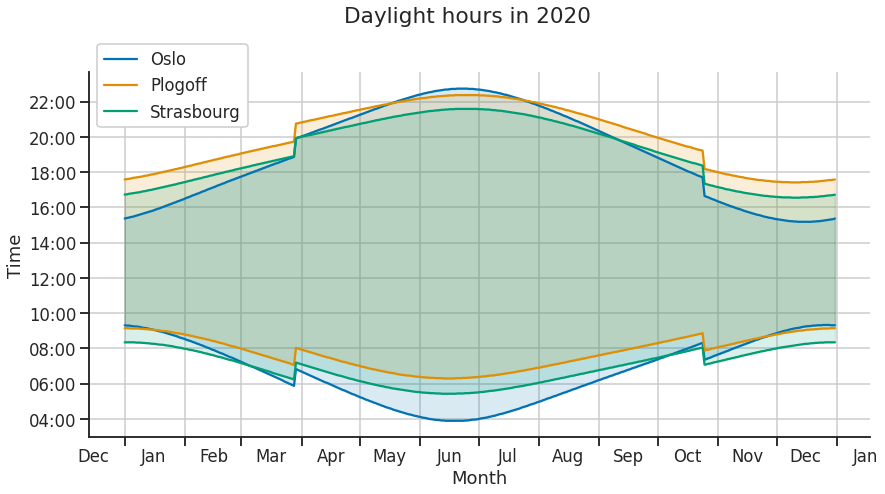

In [452]:
# Plot figure
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk') # makes fonts and lines thicker
cmap = sns.color_palette('colorblind')

f, ax = plt.subplots(figsize=(14,7))
alpha = 0.15 # transparency of fill between curves

# Oslo
ax.plot(df_daily_sunrise_oslo['Date'],df_daily_sunrise_oslo['Time of day'], color=cmap[0])
ax.plot(df_daily_sunset_oslo['Date'],df_daily_sunset_oslo['Time of day'], label='Oslo', color=cmap[0])
ax.fill_between(df['Date'], df_daily_sunrise_oslo['Time of day'], df_daily_sunset_oslo['Time of day'], color=cmap[0], alpha=alpha)

# Plogoff
ax.plot(df_daily_sunrise_plogoff['Date'],df_daily_sunrise_plogoff['Time of day'], color=cmap[1])
ax.plot(df_daily_sunset_plogoff['Date'],df_daily_sunset_plogoff['Time of day'], label='Plogoff', color=cmap[1])
ax.fill_between(df['Date'], df_daily_sunrise_plogoff['Time of day'], df_daily_sunset_plogoff['Time of day'], color=cmap[1], alpha=alpha)

# Strasbourg
ax.plot(df_daily_sunrise_strasbourg['Date'],df_daily_sunrise_strasbourg['Time of day'], color=cmap[2])
ax.plot(df_daily_sunset_strasbourg['Date'],df_daily_sunset_strasbourg['Time of day'], label='Strasbourg', color=cmap[2])
ax.fill_between(df['Date'], df_daily_sunrise_strasbourg['Time of day'], df_daily_sunset_strasbourg['Time of day'], color=cmap[2], alpha=alpha)

# Axis labels
ax.set_ylabel('Time')
ax.set_xlabel('Month')
my_y_format = mdates.DateFormatter('%H:%M')
ax.yaxis.set_major_formatter(my_y_format)
#my_x_format = mdates.DateFormatter('%-m') # a hyphen between the % and the letter removes the leading zero.
#my_x_format = mdates.DateFormatter('%b') # abreviated month
ax.xaxis.set_major_formatter(my_x_format)
ax.xaxis.set_major_locator(mdates.MonthLocator()) # major tick every month
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=16, interval=1, tz=None)) # minor tick every ~half month
ax.grid(axis='both')

# Hack to get month centered between major ticks (https://matplotlib.org/3.1.0/gallery/ticks_and_spines/centered_ticklabels.html)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

#f.autofmt_xdate() # aligns and rotates dates
sns.despine() # does same as: ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.subplots_adjust(top=0.85)
# f.legend(ncol=3, loc='upper left', frameon=False)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.1), framealpha=1)
f.suptitle("Daylight hours in {}".format(year))
plt.show()
